In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from typing import TypedDict, List
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langgraph.graph import StateGraph, END
from lib.pdf_util import extract_text_from_docx, extract_text_from_pdf
from lib.rag.util import read_chromavector, read_pgvector
from agent.rule_rag import (RULE_DIR, COLLECTION_NAME, PERSIST_DIRECTORY, CONNECTION_STRING)
from agent.llm_prompt import TEMPLATES

In [3]:
print('--- 1 Vector Store ---')
# read vectorstore
vectorstore = read_pgvector(collection_name=COLLECTION_NAME, connection_string=CONNECTION_STRING)
print(vectorstore)
print('--- 2 Retriever ---')
# Retriever 생성
retriever = vectorstore.as_retriever()
print(retriever)
print('--- 3 State ---')
class ReviewState(TypedDict):
    doc_path: str           # 입력된 docx 파일 경로
    pdf_path: str           # 변경된 pdf 파일 폴더
    format_name: str        # 문서에 적용될 룰 명
    doc_content: str        # docx에서 추출한 텍스트
    relevant_rules: str     # RAG로 검색한 관련 규칙
    review_result: dict     # LLM의 검토 결과 (JSON)
    final_report: str       # 사용자에게 전달할 최종 메시지
print('--- 4 LLM ---')
llm = ChatOpenAI(model='gpt-4.1-mini', temperature=0)

--- 1 Vector Store ---


/mnt/c/myproject/wantedocs/lib/rag/util.py:55: LangChainPendingDeprecationWarning: Please use JSONB instead of JSON for metadata. This change will allow for more efficient querying that involves filtering based on metadata. Please note that filtering operators have been changed when using JSONB metadata to be prefixed with a $ sign to avoid name collisions with columns. If you're using an existing database, you will need to create a db migration for your metadata column to be JSONB and update your queries to use the new operators. 
  return PGVector(


--- 2 Retriever ---
tags=['PGVector', 'OpenAIEmbeddings'] vectorstore=<langchain_community.vectorstores.pgvector.PGVector object at 0x7a54d8fd8f10> search_kwargs={}
--- 3 State ---
--- 4 LLM ---


In [ ]:
# 노드 2: 제목 기반 라우팅 (신규 핵심 노드) => 노드 1에서 파일 제목으로 양식 결정 할 수 있도록 변경
# def route_by_title(state: ReviewState):
#     print("--- 2. 문서 제목 분석 및 라우팅 ---")
#     prompt = ChatPromptTemplate.from_template("""
#     다음은 문서의 첫 500자입니다.
#     [문서 내용]
#     {document_preview}
#     ---
#     문서의 제목을 파악하여 이 문서가 '프로젝트 관리 양식'인지 '일일 업무 보고서'인지 판단하세요.
#     - 제목이 '프로젝트 관리' 또는 'POTEN UP' 양식과 유사하면 '프로젝트관리'
#     - 제목이 '기본 문서' 또는 'Daily Report'와 유사하면 '기본문서'
#     - 둘 다 아니면 '알수없음'
    
#     오직 '프로젝트관리', '기본문서', '알수없음' 중 하나로만 답변하세요.
#     """)
#     parser = StrOutputParser()
#     chain = prompt | llm | parser
#     # 문서의 앞부분만 잘라서 LLM에 전달
#     preview = state["doc_content"][:500] 
#     document_name = chain.invoke({"document_preview": preview})
#     print(f"--- 분석 결과: {document_name} ---")    
#     return {"name": document_name.strip()}

--- 5 Node ---
--- 6 LangGraph ---
--- complete ---


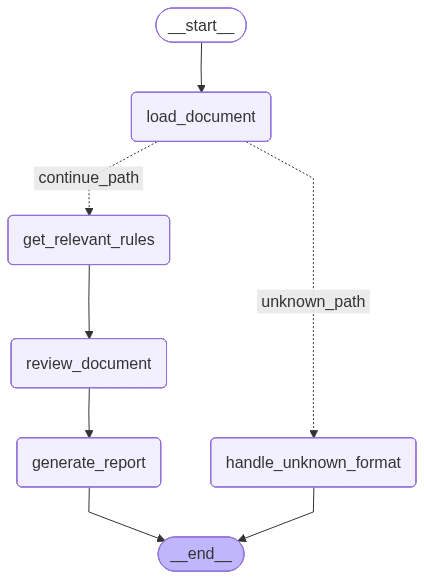

In [4]:
print('--- 5 Node ---')
# 노드 1: DOCX 파일 로드
## 실제 문서에 맞게 정의 되어야 함
DOCUMENT_NAMES = ['기본문서','프로젝트관리양식']
def load_document(state: ReviewState):
    print("--- 1. loading DOCX file ---")
    doc_path = state["doc_path"]
    pdf_path = state["pdf_path"]
    content = extract_text_from_docx(doc_path,pdf_path)
    document_name = "알수없음"
    for doc_name in DOCUMENT_NAMES:
        if doc_path.find(doc_name) >= 0:
            document_name = doc_name
            break
    return  {
                "doc_content": content,
                "format_name":document_name
            }
# 노드 2: RAG 규칙 가져오기
def get_relevant_rules(state: ReviewState):
    print(f"--- 2. RAG에서 '{state['format_name']}' 규칙 검색 중 ---")
    # 상태에 저장된 format_name 기반 RAG 필터링
    retriever = vectorstore.as_retriever(
        search_kwargs={
            "k":10, ## 규칙 크기 감안하여 사이즈 지정 필요
            "filter": {"name": state["format_name"]}
        }
    )
    # 해당 양식의 '모든' 규칙을 가져오기
    docs = retriever.invoke("양식의 모든 규칙")
    
    rules = "\n".join([doc.page_content for doc in docs])
    return {"relevant_rules": rules}
# 노드 3: LLM을 이용한 핵심 검토
def review_document(state: ReviewState):
    print(f"--- 3. LLM 문서 검토 중 (prompt : '{state['format_name']}')---")
    prompt_template = TEMPLATES[state["format_name"]]
    prompt = ChatPromptTemplate.from_template(prompt_template)
    parser = JsonOutputParser()
    chain = prompt | llm | parser
    result = chain.invoke({
        "rules": state["relevant_rules"],
        "document": state["doc_content"]
    })
    return {"review_result": result}
# 노드 4: 최종 보고서 생성
def generate_report(state: ReviewState):
    print("--- 4. 최종 보고서 생성 중 ---")
    result = state["review_result"]
    if result.get("compliant", False):
        report = "[검토 완료] 문서가 모든 양식 가이드라인을 준수합니다. 잘 작성되었습니다."
    else:
        suggestions_text = "\n".join(
            [f"- [규칙 위반: {s['rule_id']}]\n  - 원본: {s['original']}\n  - 제안: {s['suggestion']}" 
             for s in result.get("suggestions", [])]
        )
        report = f"[수정 필요] 다음 항목에 대한 검토 및 수정이 필요합니다:\n\n{suggestions_text}"
        
    return {"final_report": report}
# 노드 5: 알 수 없는 양식 처리
def handle_unknown_format(state: ReviewState):
    print("--- 5. (오류) 양식 알 수 없음 ---")
    report = "[검토 불가] 문서의 제목을 인식할 수 없습니다. '프로젝트관리양식' 또는 '기본문서'가 맞는지 확인해주세요."
    return {"final_report": report}
# 조건부 분기를 위한 라우팅 함수
def check_format_choice(state: ReviewState):
    """
    load_document 노드의 결과중 format_name를 기준으로 다음 노드를 결정합니다.
    """
    if state["format_name"] == "알수없음":
        return "unknown_path" # -> handle_unknown_format 노드로
    else:
        return "continue_path" # -> get_relevant_rules 노드로
print('--- 6 LangGraph ---')
# 그래프 워크플로우 생성
workflow = StateGraph(ReviewState)
# 노드 추가
workflow.add_node("load_document", load_document)
workflow.add_node("get_relevant_rules", get_relevant_rules)
workflow.add_node("review_document", review_document)
workflow.add_node("generate_report", generate_report)
workflow.add_node('handle_unknown_format', handle_unknown_format)
# 엣지(Edge) 연결 (작업 순서 정의)
workflow.set_entry_point("load_document")
### 조건부 엣지
workflow.add_conditional_edges(
    "load_document",     # 조건부 시작 노드
    check_format_choice, # 로직 함수
    {
        "unknown_path": "handle_unknown_format",
        "continue_path": "get_relevant_rules"
    }
)
# workflow.add_edge("load_document", "get_relevant_rules")
workflow.add_edge("get_relevant_rules", "review_document")
workflow.add_edge("review_document", "generate_report")
workflow.add_edge("generate_report", END)
# 그래프 컴파일
app = workflow.compile()
print('--- complete ---')
app

In [5]:
# 검토할 DOCX 파일
doc_to_review = "./files/1차 프로젝트관리양식.docx"
# 실행 (파일 경로, PDF 폴더를 초기 상태로 주입)
try:
    final_state = app.invoke({
        "doc_path": doc_to_review,
        "pdf_path": './pdf'
    })
    
    # 최종 결과 출력
    print("\n--- [최종 검토 결과] ---")
    print(final_state["final_report"])

except FileNotFoundError:
    print(f"오류: '{doc_to_review}' 파일을 찾을 수 없습니다.")
except Exception as e:
    print(f"에이전트 실행 중 오류 발생: {e}")

--- 1. loading DOCX file ---
*** converting './files/1차 프로젝트관리양식.docx' to pdf file in ./pdf
*** result : ./pdf/1차 프로젝트관리양식.pdf
*** reading PDF file : ./pdf/1차 프로젝트관리양식.pdf
--- 2. RAG에서 '프로젝트관리양식' 규칙 검색 중 ---
--- 3. LLM 문서 검토 중 (prompt : '프로젝트관리양식')---
--- 4. 최종 보고서 생성 중 ---

--- [최종 검토 결과] ---
[수정 필요] 다음 항목에 대한 검토 및 수정이 필요합니다:

- [규칙 위반: 1-1: 플레이스홀더 금지]
  - 원본: 1) 기획 배경
  - 제안: 필수 항목이 작성되지 않았습니다. '여기에 텍스트를 입력하세요'를 실제 내용으로 채워주세요.
- [규칙 위반: 1-1: 플레이스홀더 금지]
  - 원본: 2) 프로젝트 목표
  - 제안: 필수 항목이 작성되지 않았습니다. '여기에 텍스트를 입력하세요'를 실제 내용으로 채워주세요.
- [규칙 위반: 1-1: 플레이스홀더 금지]
  - 원본: 3) 사용 기술
  - 제안: 필수 항목이 작성되지 않았습니다. '여기에 텍스트를 입력하세요'를 실제 내용으로 채워주세요.
- [규칙 위반: 1-1: 플레이스홀더 금지]
  - 원본: 4) 팀원별 수행 역할
  - 제안: 필수 항목이 작성되지 않았습니다. '여기에 텍스트를 입력하세요'를 실제 내용으로 채워주세요.
- [규칙 위반: 1-1: 플레이스홀더 금지]
  - 원본: 5) 추진 사항 기록(daily)
  - 제안: 필수 항목이 작성되지 않았습니다. '여기에 텍스트를 입력하세요'를 실제 내용으로 채워주세요.
- [규칙 위반: 1-1: 플레이스홀더 금지]
  - 원본: 6) 강사님 피드백
  - 제안: 필수 항목이 작성되지 않았습니다. '여기에 텍스트를 입력하세요'를 실제 내용으로 채워주세요.
- [규칙 위반: 1-1: 플레이스홀더 금지]
  - 원본: 